# Uplift Modeling

In [47]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)


In [49]:
# Load the dataset
campaign = pd.read_csv('~/uplift_campaign.csv')


In [3]:
# Among other things, look at the ratio of how many people actually bought something
# (conversion10days) and how many people received a marketing incentive (treatment)
campaign.describe(include='all')

,spending10days,conversion10days,zipCode_0,zipCode_1,zipCode_2,zipCode_3,zipCode_4,zipCode_5,zipCode_6,zipCode_7,...,device_ipad,device_iphone,device_mac,device_other,conversionLastWeek,conversionLastMonth,visitLastMonth,visitLastWeek,hoursFromLastVisit,treatment
count,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000
mean,9.54018,0.161750,0.094183,0.082933,0.128450,0.088283,0.082967,0.057283,0.042850,0.162883,...,0.056667,0.129733,0.063750,0.126283,0.020267,0.042933,0.173633,0.103150,1.23920,0.500000
std,23.24368,0.368224,0.292086,0.275784,0.334593,0.283709,0.275834,0.232385,0.202521,0.369262,...,0.231207,0.336013,0.244309,0.332171,0.140912,0.202709,0.378797,0.304157,6.26341,0.500004
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.500000
75%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,588.99279,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,311.00000,1.000000


In [4]:
# Data partitioning
# Partition the data into training and test set, using 25% of the data for testing 
# We want to stratify on both conversion10days and treatment to keep the distribution between train and testing equal
from sklearn.model_selection import train_test_split
train, test = train_test_split(campaign, test_size=0.25, random_state=0, 
                               stratify=campaign[['conversion10days', 'treatment']])

In [5]:
# Check whether the data has been randomly assigned. This is an important assumptions in uplift modeling and, more generally, experimental designs. To verify a random assignment, we have to check the balance of the A/B indicator. The function checkBalance calculates standardized mean differences along each covariate and tests for conditional independence of the treatment variable and the covariates. In randomized empirical experiments the treatment and control groups should be roughly similar (i.e. balanced) in their distributions of covariates.
# Of course, we would expect the conversion rate to be different between the treatment and control group
train[['conversion10days', 'treatment']].describe()

,conversion10days,treatment
count,45000.000000,45000.000000
mean,0.161756,0.500000
std,0.368231,0.500006
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.500000
75%,0.000000,1.000000
max,1.000000,1.000000


In [6]:
test[['conversion10days', 'treatment']].describe()

,conversion10days,treatment
count,15000.000000,15000.000000
mean,0.161733,0.500000
std,0.368218,0.500017
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.500000
75%,0.000000,1.000000
max,1.000000,1.000000


In [7]:
#Data Validity

In [8]:
X = campaign.columns.drop(['conversion10days', 'treatment'])
features = campaign[X]
treatment_group = campaign[campaign.treatment == 1]
treatment_group = treatment_group[X]
control_group =  campaign[campaign.treatment == 0]
control_group = control_group[X]
agg_operations = {feature: ['mean', 'std'] for feature in features}
t_means  = treatment_group.agg(agg_operations)
c_means = control_group.agg(agg_operations)

In [9]:
# Check whether the data has been randomly assigned. This is an important assumptions in uplift modeling and, more generally, 
# experimental designs. To verify a random assignment, we have to check the balance of the A/B indicator. 
# We will calculate standardized mean differences along each covariate and tests for conditional 
# independence of the treatment variable and the covariates. In randomized empirical experiments the treatment and control groups 
# should be roughly similar (i.e. balanced) in their distributions of covariates.
# Of course, we would expect the conversion rate to be different between the treatment and control group


import scipy.stats as stats
pscores = pd.DataFrame(columns=features.columns)

for i in features.columns:
            p_score = stats.ttest_ind(
            a=treatment_group[i],
            b=control_group[i],equal_var=False)
            pscores[i] = p_score
            
pscores

,spending10days,zipCode_0,zipCode_1,zipCode_2,zipCode_3,zipCode_4,zipCode_5,zipCode_6,zipCode_7,zipCode_Foreign,...,device_windows,device_ipad,device_iphone,device_mac,device_other,conversionLastWeek,conversionLastMonth,visitLastMonth,visitLastWeek,hoursFromLastVisit
0,1.304982e+01,-0.601007,1.006618,-0.671071,0.705092,0.266407,1.036498,0.020158,0.011056,-1.349682,...,-0.083273,-0.776919,0.996283,1.487233,-1.487141,-1.506550,-0.845864,-0.387987,-0.442932,-0.451042
1,7.207899e-39,0.547837,0.314122,0.502178,0.480756,0.789927,0.299974,0.983917,0.991179,0.177123,...,0.933634,0.437210,0.319117,0.136958,0.136983,0.131931,0.397632,0.698027,0.657816,0.651961


In [10]:
table_one = campaign.groupby(campaign.treatment).agg(agg_operations)

table_one.head()

spending10days            zipCode_0           zipCode_1            \
                    mean        std      mean       std      mean       std   
treatment                                                                     
0               8.303601  21.852486  0.094900  0.293082  0.081800  0.274064   
1              10.776759  24.494199  0.093467  0.291090  0.084067  0.277492   

          zipCode_2           zipCode_3            ... conversionLastWeek  \
               mean       std      mean       std  ...               mean   
treatment                                          ...                      
0          0.129367  0.335611  0.087467  0.282522  ...           0.021133   
1          0.127533  0.333575  0.089100  0.284893  ...           0.019400   

                    conversionLastMonth           visitLastMonth            \
                std                mean       std           mean       std   
treatment                                                                    
0          0.143831            0.043633  0.204281       0.174233  0.379316   
1          0.137929            0.042233  0.201124       0.173033  0.378282   

          visitLastWeek           hoursFromLastVisit            
                   mean       std               mean       std  
treatment                                                       
0                0.1037  0.304876           1.250733  6.240067  
1                0.1026  0.303441           1.227667  6.286749  

[2 rows x 48 columns]

In [11]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features.columns:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features.columns, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,spending10days,0.1066
1,zipCode_0,0.0049
2,zipCode_1,0.0082
3,zipCode_2,0.0055
4,zipCode_3,0.0058
5,zipCode_4,0.0022
6,zipCode_5,0.0085
7,zipCode_6,0.0002
8,zipCode_7,0.0001
9,zipCode_Foreign,0.0110


In [12]:
checkBalance = pd.DataFrame()
checkBalance['mean T=0'] = c_means.values[0, :]
checkBalance['mean T=1'] = t_means.values[0, :]
checkBalance['smd'] = table_one_smd.smd.values
checkBalance['pvalue'] = pscores.loc[1 , : ].values   #subset to only get p-value of the computed table
checkBalance.index = features.columns
checkBalance
#spending10days missing here

,mean T=0,mean T=1,smd,pvalue
spending10days,8.303601,10.776759,0.1066,7.207899e-39
zipCode_0,0.094900,0.093467,0.0049,5.478374e-01
zipCode_1,0.081800,0.084067,0.0082,3.141224e-01
zipCode_2,0.129367,0.127533,0.0055,5.021781e-01
zipCode_3,0.087467,0.089100,0.0058,4.807558e-01
zipCode_4,0.082667,0.083267,0.0022,7.899267e-01
zipCode_5,0.056300,0.058267,0.0085,2.999742e-01
zipCode_6,0.042833,0.042867,0.0002,9.839172e-01
zipCode_7,0.162867,0.162900,0.0001,9.911791e-01
zipCode_Foreign,0.193333,0.189000,0.0110,1.771231e-01


In [13]:
from scipy.stats import chisquare
chisquare(campaign, axis=None)
#overall pvalue "chisquare test

Power_divergenceResult(statistic=75982051.6668006, pvalue=0.0)

In [14]:
# ATE

In [15]:
experiment = pd.crosstab(campaign['treatment'], campaign['conversion10days'], rownames=['Treatment'], colnames=['Conversion'], margins=True)
experiment

Conversion,0,1,All
Treatment,,,
0,25717,4283,30000
1,24578,5422,30000
All,50295,9705,60000


In [16]:
# The ATE is the outcome difference between the groups, assuming that individuals in each group are similar
# which is plausible because of the random sampling
# 5422/30000 - 4283/30000
(experiment.iloc[1].iloc[1]/experiment.iloc[0].iloc[2]) - (experiment.iloc[0].iloc[1]/experiment.iloc[0].iloc[2])


0.037966666666666676

In [17]:
means_spending= campaign[['spending10days', 'treatment']].groupby('treatment').mean()
means_spending

,spending10days
treatment,
0,8.303601
1,10.776759


In [18]:
10.8-8.3
ATE_spending = means_spending.iloc[1]-means_spending.iloc[0];
ATE_spending



spending10days    2.473158
dtype: float64

In [19]:
##### Difference in conditional means / Two-model approach ####
# treatment effect in group 'conversion last month'
means_twomodel= campaign[['spending10days', 'treatment',  'conversionLastMonth']].groupby(['treatment', 'conversionLastMonth'], as_index=False).mean()
means_twomodel


,treatment,conversionLastMonth,spending10days
0,0,0,8.103820
1,0,1,12.682443
2,1,0,10.212262
3,1,1,23.578412


In [20]:
# 23.6 - 12.7
means_twomodel.iloc[3].iloc[2]-means_twomodel.iloc[1].iloc[2]

10.895968680581323

In [21]:
# + 10.9 treatment effect

# treatment effect in group 'no conversion last month'

In [22]:
means_twomodel.iloc[2].iloc[2]-means_twomodel.iloc[0].iloc[2]

2.108441637598677

In [23]:
# treatment effect = +2.1 
# -> The coupon seems to have a bigger effect on recent buyers!


In [37]:
# split data in control and treatment group
# for regression to control for all variables by estimating conditional means
reg_control = train[train.treatment==1]
reg_treatment = train[train.treatment==0]

# create list with column names for X and y and T
X = campaign.columns.drop(['treatment', 'spending10days', 'conversion10days'])
y = 'spending10days'
T = 'treatment'

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
regressor = LinearRegression()  


regressor.fit(reg_treatment[X], reg_treatment[y]) #training the algorithm
y_predT = regressor.predict(test[X])
regressor.fit(reg_control[X], reg_control[y]) 
y_predC = regressor.predict(test[X])

In [26]:
pred = pd.DataFrame() #create a dataframe to store results
pred['twomodel'] =  (y_predT[:, 0])- (y_predC[:, 0]) #subtract both predictions from another
np.mean(pred.twomodel)


-2.409921459803219

In [27]:

#### Outcome Transformation ####

In [28]:
train_spending_TO = train.spending10days*train.treatment/0.5 - (1-train.treatment)*train.spending10days/0.5
test_spending_TO = test.spending10days*test.treatment/0.5 - (1-test.treatment)*test.spending10days/0.5

print(np.mean(train_spending_TO))
# The transformed outcome has the same expected value as the ATE, but more variance


2.4507018164052146


In [29]:
# Transformed outcome regression

regressor.fit(train[X], train_spending_TO) #train model on transformed outcome 
pred['reg_TO'] = regressor.predict(test[X])
pred


,twomodel,reg_TO
0,-0.982414,1.576969
1,-6.565176,5.929089
2,-1.868552,1.908265
3,-2.308072,2.269448
4,2.816984,-2.530008
...,...,...
14995,-1.202406,1.533991
14996,-1.196218,1.742744
14997,-2.880666,2.644643
14998,-1.202406,1.533991


In [ ]:
#edit data for casual ml 

train.treatment[train.treatment == 0] = 'control' ;
train.treatment[train.treatment == 1] = 'treatment';

In [41]:
train.t

,spending10days,conversion10days,zipCode_0,zipCode_1,zipCode_2,zipCode_3,zipCode_4,zipCode_5,zipCode_6,zipCode_7,...,device_ipad,device_iphone,device_mac,device_other,conversionLastWeek,conversionLastMonth,visitLastMonth,visitLastWeek,hoursFromLastVisit,treatment
10458,42.409041,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,treatment
40018,0.000000,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,control
38222,0.000000,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,control
59721,0.000000,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,2,control
16419,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54952,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,control
19428,0.000000,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,treatment
40048,0.000000,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,control
15514,0.000000,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,treatment


In [43]:
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_RF = UpliftRandomForestClassifier(control_name='control')

uplift_RF.fit(train[X].values,
                 treatment=train[T].values,
                 y=train[y].values) ;

In [44]:
pred['Causal_RF'] = uplift_RF.predict(test[X].values).ravel() #ravel extracts the values from the numpy array so it can be loaded into the dataframe

In [45]:
#### Performance Assessment for Uplift Models ####
# Analyze the predicted values
np.mean(pred)
# The causal forest is not in line with the other models and the ATE


twomodel    -2.409921
reg_TO       2.451557
Causal_RF    2.480962
dtype: float64

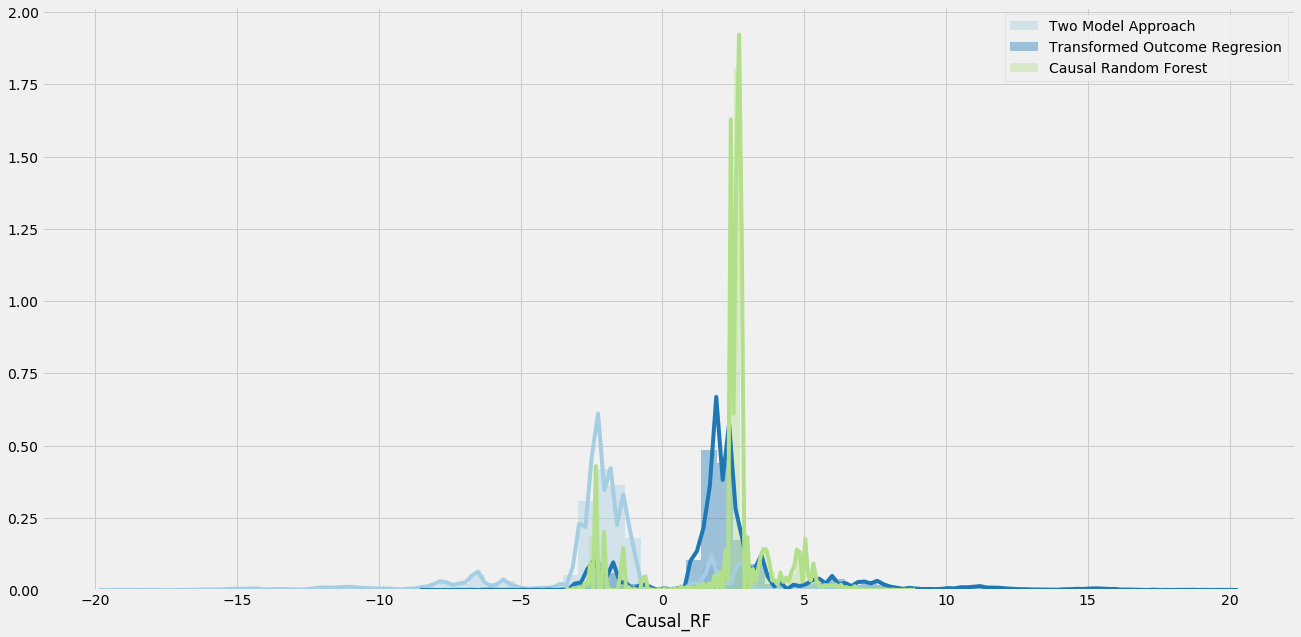

In [46]:
# Let's check what the models estimate on the individual level

import seaborn as sns
sns.distplot(pred['twomodel'], label="Two Model Approach")
sns.distplot(pred['reg_TO'], label= 'Transformed Outcome Regresion')
sns.distplot(pred['Causal_RF'], label = 'Causal Random Forest')
plt.legend() ;

In [ ]:
# There seem to be many cases where the treatment decreases conversion!